<a href="https://colab.research.google.com/github/pullz6/Research_inspired_Self-Explaining-Neural-Networks-for-Business-Process-Monitoring/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [55]:
!pip install mlflow -q

In [56]:
!pip install pyngrok -q

In [57]:
!pip install --upgrade mlflow>=2.3.0

In [58]:
#Importing libraries
import mlflow
from mlflow.data.pandas_dataset import PandasDataset
import subprocess
from pyngrok import ngrok, conf
import getpass


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [59]:
print(mlflow.__version__)

2.22.0


In [60]:
def set_mlflow():
  get_ipython().system_raw("mlflow ui --port 5000 &")
  ngrok.kill()
  NGROK_AUTH_TOKEN = "2slIw2XdGuFjpkotlKi9OYKkNxH_5dr7FtkWh4qMxea6sUoat"
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)
  ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
  print("MLflow Tracking UI:", ngrok_tunnel.public_url)
  return ngrok_tunnel.public_url

In [61]:
uri = set_mlflow()
mlflow.set_tracking_uri(uri=uri)

MLflow Tracking UI: https://56a8-35-184-158-114.ngrok-free.app


In [63]:
mlflow.set_experiment("Prediction Activity - LSTM")

<Experiment: artifact_location='mlflow-artifacts:/704826602000200303', creation_time=1748875797459, experiment_id='704826602000200303', last_update_time=1748875797459, lifecycle_stage='active', name='Prediction Activity - LSTM', tags={}>

In [64]:
df = pd.read_csv("Helpdesk.csv")

In [65]:
def prepare_data(df):
  #Simple data prep
  df.drop_duplicates(inplace=True)
  df['case:variant-index'] = df['case:variant-index'].apply(lambda x: int(x))
  df['Resource'] = df['Resource'].str.strip().str[-1]
  df['Resource'] = df['Resource'].apply(lambda x: int(x))
  df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)

  #Creating a new column for date and formatting the date type
  df['new_date'] = df['time:timestamp'].dt.date
  df['new_date'] = pd.to_datetime(df['new_date'], utc=True)
  df['new_time'] = pd.to_datetime(df['time:timestamp'].dt.time.astype(str), format='%H:%M:%S').dt.floor('S')

  #Creating a new column for the time a case started per each entry
  min_timestamps = df.groupby('case:concept:name')['time:timestamp'].transform('min')
  df['time_lapsed'] = df['time:timestamp'] - min_timestamps
  df['time_lapsed'] = pd.to_timedelta(df['time_lapsed'])
  df['time_lapsed'] = df['time_lapsed'].dt.total_seconds()

  max_len = len(df['concept:name'].unique())

  #Lets drop uneccessary columns
  df.drop(['concept:name','org:resource','case:creator','lifecycle:transition','case:variant'],axis=1, inplace=True)

  #Lets create a stage number for each activity stage of the help desk, this will help us easily identify where the case is in terms of the process
  stage = pd.DataFrame()
  stage['Stage_no'] = [1,2,3,4,5,6,7,7.1,7.2,8,9,9.1,9.2,10]
  stage['Activity'] = ['Insert ticket','Assign seriousness','Take in charge ticket','Wait','Require upgrade','Schedule intervention','Resolve ticket','Create SW anomaly','Resolve SW anomaly','VERIFIED','RESOLVED','INVALID', 'DUPLICATE','Closed']

  df=pd.merge(df,stage,on='Activity', how='left')

  return max_len, df

In [66]:
max_len, df = prepare_data(df)

<ipython-input-65-e86bb61dc76d>:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['new_time'] = pd.to_datetime(df['time:timestamp'].dt.time.astype(str), format='%H:%M:%S').dt.floor('S')


In [67]:
max_len

14

In [68]:
df.head()

,time:timestamp,Activity,Resource,case:concept:name,case:variant-index,new_date,new_time,time_lapsed,Stage_no
0,2010-01-13 06:40:25+00:00,Assign seriousness,2,Case3608,33,2010-01-13 00:00:00+00:00,1900-01-01 06:40:25,0.0,2.0
1,2010-01-29 06:52:27+00:00,Take in charge ticket,2,Case3608,33,2010-01-29 00:00:00+00:00,1900-01-01 06:52:27,1383122.0,3.0
2,2010-01-29 06:52:34+00:00,Resolve ticket,2,Case3608,33,2010-01-29 00:00:00+00:00,1900-01-01 06:52:34,1383129.0,7.0
3,2010-02-13 06:52:48+00:00,Closed,5,Case3608,33,2010-02-13 00:00:00+00:00,1900-01-01 06:52:48,2679143.0,10.0
4,2010-01-13 10:26:04+00:00,Assign seriousness,2,Case2748,1,2010-01-13 00:00:00+00:00,1900-01-01 10:26:04,0.0,2.0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21221 entries, 0 to 21220
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   time:timestamp      21221 non-null  datetime64[ns, UTC]
 1   Activity            21221 non-null  object             
 2   Resource            21221 non-null  int64              
 3   case:concept:name   21221 non-null  object             
 4   case:variant-index  21221 non-null  int64              
 5   new_date            21221 non-null  datetime64[ns, UTC]
 6   new_time            21221 non-null  datetime64[ns]     
 7   time_lapsed         21221 non-null  float64            
 8   Stage_no            21221 non-null  float64            
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 1.5+ MB


One-Hot Encoding

In [70]:
from sklearn.preprocessing import OneHotEncoder

In [71]:
def one_hot_encode(df, column_name):
  one_hot_enc = OneHotEncoder(sparse_output=False)
  arr = one_hot_enc.fit_transform(df[[column_name]])
  feature_names = one_hot_enc.get_feature_names_out([column_name])
  df_encoded = pd.DataFrame(arr, columns=feature_names)
  df.drop(column_name, axis=1, inplace=True)
  df = pd.concat([df, df_encoded], axis=1)
  return df

In [72]:
df = one_hot_encode(df, 'Stage_no')

In [73]:
df.head()

,time:timestamp,Activity,Resource,case:concept:name,case:variant-index,new_date,new_time,time_lapsed,Stage_no_1.0,Stage_no_2.0,...,Stage_no_5.0,Stage_no_6.0,Stage_no_7.0,Stage_no_7.1,Stage_no_7.2,Stage_no_8.0,Stage_no_9.0,Stage_no_9.1,Stage_no_9.2,Stage_no_10.0
0,2010-01-13 06:40:25+00:00,Assign seriousness,2,Case3608,33,2010-01-13 00:00:00+00:00,1900-01-01 06:40:25,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-29 06:52:27+00:00,Take in charge ticket,2,Case3608,33,2010-01-29 00:00:00+00:00,1900-01-01 06:52:27,1383122.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-29 06:52:34+00:00,Resolve ticket,2,Case3608,33,2010-01-29 00:00:00+00:00,1900-01-01 06:52:34,1383129.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-02-13 06:52:48+00:00,Closed,5,Case3608,33,2010-02-13 00:00:00+00:00,1900-01-01 06:52:48,2679143.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2010-01-13 10:26:04+00:00,Assign seriousness,2,Case2748,1,2010-01-13 00:00:00+00:00,1900-01-01 10:26:04,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
df.columns

Index(['time:timestamp', 'Activity', 'Resource', 'case:concept:name',
       'case:variant-index', 'new_date', 'new_time', 'time_lapsed',
       'Stage_no_1.0', 'Stage_no_2.0', 'Stage_no_3.0', 'Stage_no_4.0',
       'Stage_no_5.0', 'Stage_no_6.0', 'Stage_no_7.0', 'Stage_no_7.1',
       'Stage_no_7.2', 'Stage_no_8.0', 'Stage_no_9.0', 'Stage_no_9.1',
       'Stage_no_9.2', 'Stage_no_10.0'],
      dtype='object')

Splitting Data

In [75]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
X_sequences = []
y_act = []
y_time = []

In [77]:
case_groups = df.groupby('case:concept:name')
max_len = 14  # As per your model's expected timesteps
num_features = 15  # Must match your feature count

In [78]:
features_col = ['Stage_no_1.0', 'Stage_no_2.0', 'Stage_no_3.0', 'Stage_no_4.0',
       'Stage_no_5.0', 'Stage_no_6.0', 'Stage_no_7.0', 'Stage_no_7.1',
       'Stage_no_7.2', 'Stage_no_8.0', 'Stage_no_9.0', 'Stage_no_9.1',
       'Stage_no_9.2', 'Stage_no_10.0','Resource']

In [79]:
sequence = ['Stage_no_1.0', 'Stage_no_2.0', 'Stage_no_3.0', 'Stage_no_4.0',
       'Stage_no_5.0', 'Stage_no_6.0', 'Stage_no_7.0', 'Stage_no_7.1',
       'Stage_no_7.2', 'Stage_no_8.0', 'Stage_no_9.0', 'Stage_no_9.1',
       'Stage_no_9.2', 'Stage_no_10.0']

In [80]:
group_sizes = [len(group) for _, group in df.groupby('case:concept:name')]
print("Group sizes:", sum(group_sizes))

Group sizes: 21221


In [81]:
len(group_sizes)

4580

In [82]:
df['time_lapsed'] = df['time_lapsed'].mask(df['time_lapsed'] == 0, 0.1)

Before we apply any normalization, lets check the distribution of the time lapsed.

Our model is consisting of LSTM units, they do not perform well with skewness well.

We need to address this prior to fitting the data.

<Figure size 640x480 with 0 Axes>

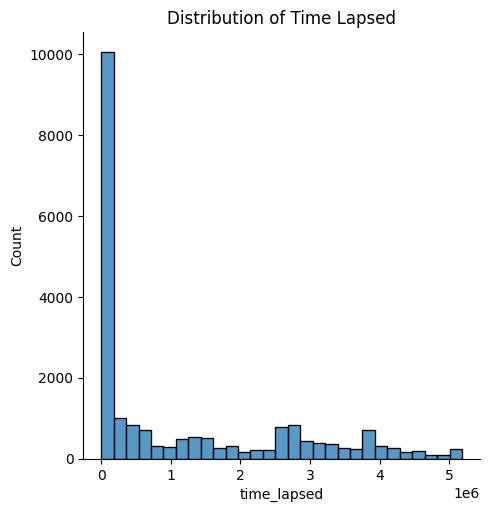

In [83]:
plt.figure()
sns.displot(df, x="time_lapsed")
plt.title('Distribution of Time Lapsed')
plt.show()

In [84]:
from sklearn.preprocessing import MinMaxScaler

#df['time_lapsed'] = MinMaxScaler().fit_transform(np.array(df['time_lapsed']).reshape(-1,1))

df['time_lapsed'], fitted_lambda = stats.boxcox(df['time_lapsed'])

<Figure size 640x480 with 0 Axes>

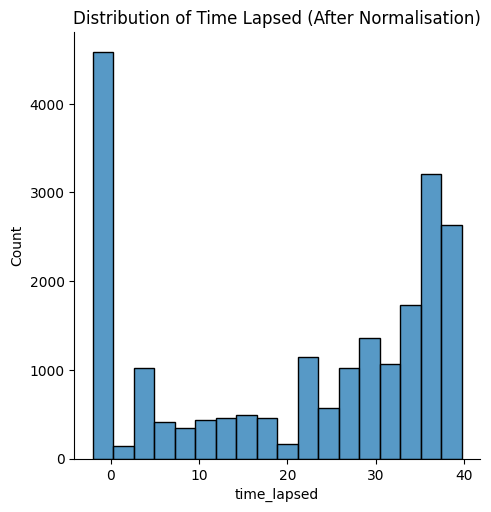

In [85]:
plt.figure()
sns.displot(df, x="time_lapsed")
plt.title('Distribution of Time Lapsed (After Normalisation)')
plt.show()

Now lets see the resource variable.

<Figure size 640x480 with 0 Axes>

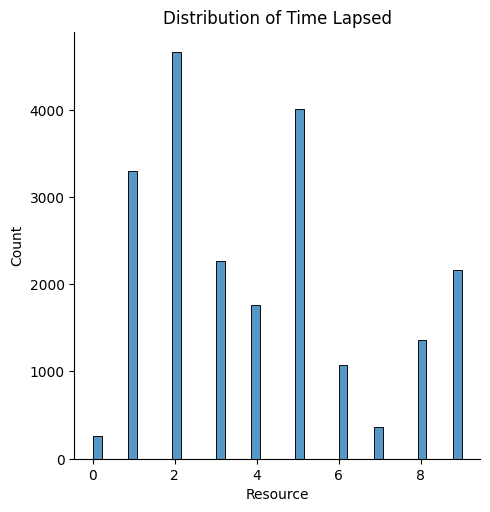

In [86]:
plt.figure()
sns.displot(df, x="Resource")
plt.title('Distribution of Time Lapsed')
plt.show()

Has a distribution similar to a normal distribution, so lets do normal min max scaling.

In [87]:
df['Resource'] = (df['Resource'] - df['Resource'].min()) / (df['Resource'].max() - df['Resource'].min())

Lets creating our training data

In [88]:
for _, group in case_groups:
    #Lets sort of the values
    group = group.sort_values('time:timestamp')

    #Lets do normalization
    group['time_lapsed'] = group['time_lapsed'].astype('float32')

    # Process each row individually
    for _, row in group.iterrows():
        # Get features for this single row (shape: [15] for 15 features)
        features = row[features_col].values

        # Reshape to (1, 15) since pad_sequences expects sequences
        features = features.reshape(1, -1)

        # Pad to (14, 15)
        padded = pad_sequences(
            [features],  # Note the list wrapping
            maxlen=max_len,  # 14
            padding='post',
            truncating='post',
            dtype='float32'
        )[0]  # Take the first element to remove extra dimension
        X_sequences.append(padded)

    #Creating the data for y_act
    temp_y_act = group[sequence].to_numpy()
    temp_y_act = np.vstack([
      temp_y_act[1:,:],  # All rows after first
      np.zeros((1, temp_y_act.shape[1]))  # Add zero row at end
    ])
    y_act.extend(temp_y_act)


    #Creating the data for y_time
    temp_y_time = group['time_lapsed'].to_numpy()
    temp_y_time = np.concatenate([
        temp_y_time[1:],  # Elements after first
        [0]  # Append zero
    ])
    y_time.extend(temp_y_time)

In [89]:
y_act = np.array(y_act)
X_sequences = np.array(X_sequences)
y_time = np.array(y_time)

In [90]:
print('Size of X:'+ str(X_sequences.shape))
print('Size of y_act:'+ str((y_act).shape))
print('Size of y_time:'+ str((y_time).shape))

Size of X:(21221, 14, 15)
Size of y_act:(21221, 14)
Size of y_time:(21221,)


In [91]:
print('Sample of X:'+ str(X_sequences[0]))
print('Sample of y_act:'+ str(y_act[0]))
print('Sample of y_time:'+ str(y_time[0]))

Sample of X:[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.11111111]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.    

In [92]:
#Logging the dataset into MLFlow
dataset_source_url = 'https://github.com/pullz6/Research_inspired_Self-Explaining-Neural-Networks-for-Business-Process-Monitoring/blob/main/Data/Helpdesk.csv'
dataset = mlflow.data.from_pandas(
    df, source=dataset_source_url, name="HelpDesk", targets="Activity"
)

/usr/local/lib/python3.11/dist-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'https://github.com/pullz6/Research_inspired_Self-Explaining-Neural-Networks-for-Business-Process-Monitoring/blob/main/Data/Helpdesk.csv'. Exception: 
  return _dataset_source_registry.resolve(


Model building

In [93]:
!pip install keras

In [94]:
#Creating the model architecture

In [95]:
#Importing the required libriares since the LSTM model will be done with Pytorch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Input
from keras.utils import get_file
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D

from mlflow.types.schema import Schema, TensorSpec
from mlflow.models import ModelSignature

In [96]:
main_input = Input(shape=(max_len, num_features), name='main_input')

In [97]:
main_input

<KerasTensor shape=(None, 14, 15), dtype=float32, sparse=False, name=main_input>

In [98]:
#start auto-logging and run
mlflow.tensorflow.autolog()
run = mlflow.start_run(
)

In [99]:
#Create the training split

In [100]:
l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer

b1 = BatchNormalization()(l1)

l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction

b2_1 = BatchNormalization()(l2_1)

l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction

b2_2 = BatchNormalization()(l2_2)

act_output = Dense(14, activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(b2_1)

time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

#time_output = GlobalAveragePooling1D()(b2_2)  # Reduces (14,64) to (64,)
#time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')#(time_output)

In [101]:
learning_rate = 0.002
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.004
clipvalue = 3
model = Model(inputs=[main_input], outputs=[act_output, time_output])

opt = Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, weight_decay=weight_decay, clipvalue=clipvalue)

model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mae'}, optimizer=opt)

early_stopping = EarlyStopping(monitor='val_loss', patience=42)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [102]:
#Setting the input and output schema
input_schema = Schema([TensorSpec(np.dtype('float32'),(-1,14,15),'input_features')])

output_schema = Schema([TensorSpec(np.dtype('float32'),(-1,14),'output_activity'),TensorSpec(np.dtype('float32'),(-1,1),'output_time')])

model_signature = ModelSignature(inputs=input_schema, outputs=output_schema)

Model Training

In [103]:
model.fit(
    X_sequences,
    {'act_output': y_act, 'time_output': y_time},
    validation_split=0.2,
    verbose=2,
    batch_size=max_len,
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 14, 15))
  warnings.warn(msg)


1213/1213 - 54s - 44ms/step - act_output_loss: 0.9419 - loss: 9.8798 - time_output_loss: 8.9364 - val_act_output_loss: 1.4532 - val_loss: 6.2524 - val_time_output_loss: 4.7953
Epoch 2/50
1213/1213 - 84s - 69ms/step - act_output_loss: 1.1979 - loss: 8.4719 - time_output_loss: 7.2743 - val_act_output_loss: 1.1990 - val_loss: 6.9350 - val_time_output_loss: 5.7274
Epoch 3/50


1213/1213 - 83s - 69ms/step - act_output_loss: 1.3909 - loss: 8.5539 - time_output_loss: 7.1628 - val_act_output_loss: 1.1575 - val_loss: 6.1819 - val_time_output_loss: 5.0177
Epoch 4/50


1213/1213 - 98s - 81ms/step - act_output_loss: 1.4793 - loss: 8.5362 - time_output_loss: 7.0569 - val_act_output_loss: 1.1507 - val_loss: 6.1125 - val_time_output_loss: 4.9569
Epoch 5/50
1213/1213 - 67s - 56ms/step - act_output_loss: 1.6431 - loss: 8.7571 - time_output_loss: 7.1146 - val_act_output_loss: 1.3347 - val_loss: 6.2406 - val_time_output_loss: 4.9016
Epoch 6/50


1213/1213 - 83s - 68ms/step - act_output_loss: 1.6370 - loss: 8.8502 - time_output_loss: 7.2127 - val_act_output_loss: 1.1470 - val_loss: 6.0153 - val_time_output_loss: 4.8615
Epoch 7/50
1213/1213 - 79s - 65ms/step - act_output_loss: 1.6871 - loss: 8.7326 - time_output_loss: 7.0453 - val_act_output_loss: 1.1948 - val_loss: 6.5900 - val_time_output_loss: 5.3926
Epoch 8/50


1213/1213 - 79s - 65ms/step - act_output_loss: 1.8404 - loss: 8.9177 - time_output_loss: 7.0757 - val_act_output_loss: 1.1508 - val_loss: 5.9948 - val_time_output_loss: 4.8379
Epoch 9/50


1213/1213 - 81s - 67ms/step - act_output_loss: 1.7935 - loss: 8.9779 - time_output_loss: 7.1871 - val_act_output_loss: 1.1651 - val_loss: 5.8118 - val_time_output_loss: 4.6425
Epoch 10/50
1213/1213 - 40s - 33ms/step - act_output_loss: 1.7374 - loss: 8.8656 - time_output_loss: 7.1272 - val_act_output_loss: 1.2062 - val_loss: 6.3037 - val_time_output_loss: 5.0941
Epoch 11/50
1213/1213 - 41s - 33ms/step - act_output_loss: 1.8230 - loss: 8.8549 - time_output_loss: 7.0333 - val_act_output_loss: 1.2141 - val_loss: 6.4188 - val_time_output_loss: 5.2004
Epoch 12/50
1213/1213 - 41s - 34ms/step - act_output_loss: 1.7412 - loss: 8.8372 - time_output_loss: 7.0993 - val_act_output_loss: 1.2070 - val_loss: 6.5231 - val_time_output_loss: 5.3124
Epoch 13/50
1213/1213 - 41s - 34ms/step - act_output_loss: 1.6536 - loss: 8.6910 - time_output_loss: 7.0374 - val_act_output_loss: 1.2160 - val_loss: 6.4470 - val_time_output_loss: 5.2251
Epoch 14/50
1213/1213 - 42s - 35ms/step - act_output_loss: 1.8449 - loss

2025/06/02 15:40:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(5, 14, 15))"


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [104]:
model_info = mlflow.keras.log_model(
    model=model,
    artifact_path="Prediction Model",
    registered_model_name="Prediction-Model",
    signature=model_signature
)

Successfully registered model 'Prediction-Model'.
2025/06/02 15:40:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Prediction-Model, version 1
Created version '1' of model 'Prediction-Model'.


In [105]:
mlflow.log_params(
                params={
                    "learning_rate": learning_rate,
                    "beta_1 ": beta_1 ,
                    "beta_2": beta_2,
                    "epsilon": epsilon,
                    "weight_decay": weight_decay,
                    "clipvalue": clipvalue
                }
            )